In [1]:
#Importing and notebook setup
%matplotlib inline
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.optimize as optimization

In [8]:
#Data import
data= pd.read_csv('C:/users/rscsa/Research/radvel-master/HD75732/HD75732.csv')

In [12]:
#Data import
data= pd.read_csv('C:/users/rscsa/Research/radvel-master/HD75732/HD75732.csv')

#Naming Variables from data
t = np.array(data.jd)
vel = np.array(data.mnvel)
errvel = np.array(data.errvel)

#best fit time vector
time = np.linspace(t[0]-1,t[-1]+1,num=10000)

In [47]:
#Finding Best Fit Equation
def func(x, amp, period, verti9cal_shift,horizontal_shift):
    return amp*np.sin((period)*(x-horizontal_shift))+vertical_shift

#Parameters from best fit
param = optimization.curve_fit(func,t, vel)[0]

#Best Fit Fuction
best_fit = func(time, param[0], param[1], param[2],param[3])


print "Guess of Model"
print 'Amplitude: ', param[0]
print 'Period: ', param[1]
print 'H Shift: ', param[2]
print 'v Shift', param[3]

NameError: global name 'vertical_shift' is not defined

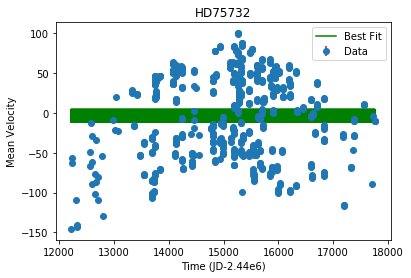

In [27]:
#Data Plotting with best fit
plt.figure()
plt.xlabel('Time (JD-2.44e6)')
plt.ylabel('Mean Velocity')
plt.errorbar(t,vel,yerr=errvel, fmt='o', ecolor='red', label='Data')
plt.plot(time,best_fit,color='green',label='Best Fit')
plt.title('HD75732')
plt.legend()
# plt.xlim(t[0],t[0]+100)

(0, 8)

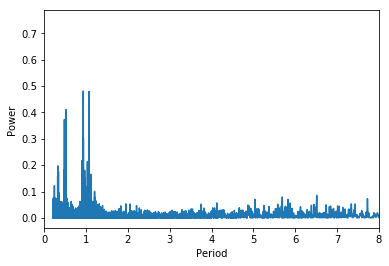

In [31]:
#using Lomb-Scargle Power (CORRECT)
#from gatspy
from gatspy.periodic import LombScargleFast
model = LombScargleFast().fit(t, vel)
period, power = model.periodogram_auto(nyquist_factor=80)

#Plotting
plt.figure
plt.plot(period,power)
plt.ylabel('Power')
plt.xlabel('Period')# days
plt.xlim(0,8)

In [32]:
# set range and find period (Correct)
model.optimizer.period_range=(.3, 2)
period = model.best_period
print("period = {0}".format(period))

Finding optimal frequency:
 - Estimated peak width = 0.00113
 - Using 5 steps per peak; omega_step = 0.000227
 - User-specified period range:  0.3 to 2
 - Computing periods at 78567 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
period = 0.933721675556


In [33]:
import matplotlib
import numpy as np
import pylab as pl
import pandas as pd
from scipy import optimize

import corner

import radvel
import radvel.plotting

matplotlib.rcParams['font.size'] = 14

In [40]:
#initional model
def initialize_model():
    time_base = 2420
    params = radvel.RVParameters(1,basis='per tc secosw sesinw logk')
    params['per1'] = 4.23078166873     # period of 1st planet
    params['tc1'] = 2072.79438    # time of inferior conjunction of 1st planet
    params['secosw1'] = 0.01
    params['sesinw1'] = 0.01
    params['logk1'] = 1.301     # velocity semi-amplitude for 1st planet
    
    mod = radvel.RVModel(params, time_base=time_base)
    mod.params['dvdt'] = 0.0         # slope
    mod.params['curv'] = 0.0         # curvature  
    return mod

In [41]:
#plotting definition
def plot_results(like):
    fig = pl.figure(figsize=(12,4))
    fig = pl.gcf()
    pl.errorbar(
        like.x, like.model(t)+like.residuals(), 
        yerr=like.yerr, fmt='o'
        )
    pl.plot(ti, like.model(ti))
    fig.set_tight_layout(True)
    pl.xlabel('Time')
    pl.ylabel('RV')
    pl.draw()

In [42]:
#Obtaining data
rv = data
t = np.array(rv.jd)
vel = np.array(rv.mnvel)
errvel = np.array(rv.errvel)
ti = np.linspace(rv.jd.iloc[0]-5,rv.jd.iloc[-1]+5,1000)

In [43]:

mod = initialize_model()
like = radvel.likelihood.RVLikelihood(mod, t, vel, errvel)
like.params['gamma'] = 1.0
like.params['jit'] = 1.0

In [44]:
like.vary['curv'] = True
print like

parameter                     value      vary
curv                              0       True
dvdt                              0       True
gamma                             1       True
jit                               1       True
logk1                         1.301       True
per1                        4.23078       True
secosw1                        0.01       True
sesinw1                        0.01       True
tc1                         2072.79       True



C:\Users\rscsa\Anaconda2\lib\site-packages\matplotlib\figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


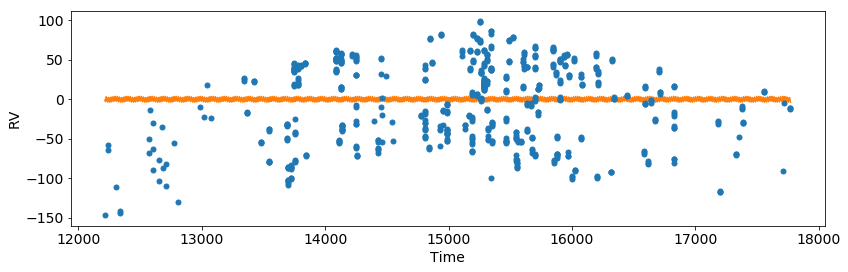

In [45]:
#plotting data with model
pl.figure()
plot_results(like)

In [46]:
#post from model data
post = radvel.posterior.Posterior(like)

print post

parameter                     value      vary
curv                              0       True
dvdt                              0       True
gamma                             1       True
jit                               1       True
logk1                         1.301       True
per1                        4.23078       True
secosw1                        0.01       True
sesinw1                        0.01       True
tc1                         2072.79       True

Priors
------

